## 목적
- 3가지 모델(random forest, xgboost, lightgbm)의 성능 비교
- 추후에도 모델 변경 시 비교를 빠르게 하기 위함

## 설계
- data
    - comm.user_input_matrix_for_upsell_monthly / 1월 데이터
    - trn_val / test 로 8:2 split
    - trn_val에서 label이 0인 데이터를 down-sampling 
- model
    - trn_val(or sample_trn_val)을 trn / val로 8:2 split
    - lightgbm 
- evaluation
    - 이전에 split한 test data 사용 
    - 비교 metric: auprc
- code

## package

In [1]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

In [2]:
from sm_utils import sampling, evaluate, show_results, save_model, load_model

/home/dmig/py_libs/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
x_test = pd.read_pickle('../data/x_test.pkl')
y_test = pd.read_pickle('../data/y_test.pkl')

sample_x_trn = pd.read_pickle('../data/sample_x_trn.pkl')
sample_x_val = pd.read_pickle('../data/sample_x_val.pkl')
sample_y_trn = pd.read_pickle('../data/sample_y_trn.pkl')
sample_y_val = pd.read_pickle('../data/sample_y_val.pkl')

print('x_test: ', x_test.shape)
print('y_test: ', y_test.shape)
print('sample_x_trn: ', sample_x_trn.shape)
print('sample_x_val: ', sample_x_val.shape)
print('sample_y_trn: ', sample_y_trn.shape)
print('sample_y_val: ', sample_y_val.shape)

x_test:  (3635243, 79)
y_test:  (3635243, 1)
sample_x_trn:  (1290672, 79)
sample_x_val:  (322668, 79)
sample_y_trn:  (1290672, 1)
sample_y_val:  (322668, 1)


In [14]:
feature_cols = list(x_test.columns)

## Random forest

In [14]:
rf_params = {
    'n_estimators': 400,
#     'max_feature': ,
    'max_depth':8,
#     'min_samples_split': ,
#     'bootstrap': ,
    'n_jobs': 30,
    'random_state': 23,
#     'verbose': 2
}

In [16]:
rf = RandomForestClassifier(**rf_params)

In [17]:
rf.fit(sample_x_trn, sample_y_trn)

/opt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=30, oob_score=False, random_state=23, verbose=0,
                       warm_start=False)

### evaluate

In [18]:
rf_result_dict = evaluate(x_test, y_test.label.values, rf, 'rf')

acc    recall  precision  f1_score       auc
0  0.979094  0.098776   0.301066  0.148749  0.809079

pred: 1  pred: 0
true: 1     6640    60583
true: 0    15415  3552605

feature              desc  importance
6            last_equip_period               NaN    0.121156
27      data_usage_in_gb_bf_m1         총 데이터 사용량    0.071026
53            data_usage_ratio               NaN    0.069007
28      data_usage_in_gb_bf_m2         총 데이터 사용량    0.063116
44     avg_subscription_period      평균 요금제 변경 주기    0.058854
49               real_avg_arpu           평균 ARPU    0.052433
54  bf_m6_data_usage_ratio_avg         데이터 소진 비율    0.034868
7                  bas_fee_amt            요금제 가격    0.033631
8              bas_ofr_data_gb               NaN    0.031985
30                 overage_bf0               NaN    0.026245
56   bf_m3_data_over_usage_cnt      데이터 초과 사용 횟수    0.025984
58           copn_left_cnt_bf1  쿠폰 소진 후 잔여 쿠폰 건수    0.025730
59           copn_left_cnt_bf2  쿠폰 소진 후 잔여 쿠폰 건수    0.023069
50           bf_m3_fee_chg_cnt      요금제 변경 횟수 피쳐    0.022881
55   bf_m6_data_over_usage_cnt      데이터 초과 사용 횟수    0.022320
46             real_arpu_bf_m1           순수 ARPU    0.022212
48             real_arpu_bf_m3           순수 ARPU    0.021606
5              svc_scrb_period               NaN    0.020747
47             real_arpu_bf_m2           순수 ARPU    0.020247
18    twld_fee_visit_cnt_bf_m0               NaN    0.019174

## Xgboost

In [93]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc', #logloss, error, auc
    'n_estimators': 2000,
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'scale_pos_weight': 4, # neg/pos
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 23,
    'nthread': 60,
    'verbosity': 1
}

In [94]:
clf2 = xgb.XGBClassifier(**xgb_params)

In [39]:
t1 = time.time()
clf2.fit(sample_x_trn.values, sample_y_trn.label.values, 
         eval_set=[(sample_x_trn.values, sample_y_trn.label.values), 
                   (sample_x_val.values, sample_y_val.label.values)],
        early_stopping_rounds=100, verbose=50)
print('elapsed time: ', time.time()-t1importance_y)

[0]	validation_0-auc:0.766535	validation_1-auc:0.765371
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.888884	validation_1-auc:0.887396
[100]	validation_0-auc:0.914431	validation_1-auc:0.912307
[150]	validation_0-auc:0.927693	validation_1-auc:0.924722
[200]	validation_0-auc:0.93473	validation_1-auc:0.931098
[250]	validation_0-auc:0.939911	validation_1-auc:0.935712
[300]	validation_0-auc:0.944495	validation_1-auc:0.939815
[350]	validation_0-auc:0.947278	validation_1-auc:0.942044
[400]	validation_0-auc:0.950645	validation_1-auc:0.944969
[450]	validation_0-auc:0.953107	validation_1-auc:0.946836
[500]	validation_0-auc:0.955955	validation_1-auc:0.949384
[550]	validation_0-auc:0.957547	validation_1-auc:0.950488
[600]	validation_0-auc:0.958825	validation_1-auc:0.951317
[650]	validation_0-auc:0.960063	validation_1-auc:0.952089
[700]	validation_0-auc:0.961255	va

acc    recall  precision  f1_score       auc
0  0.908471  0.869539   0.152853  0.260001  0.961074

pred: 1  pred: 0
true: 1    58453     8770
true: 0   323961  3244059

feature              desc  importance
42                 sec_dev_yn     세컨드 디바이스 보유여부    0.060281
12                  family_yn          가족 결합 여부    0.044345
8             bas_ofr_data_gb               NaN    0.042611
56  bf_m3_data_over_usage_cnt      데이터 초과 사용 횟수    0.042249
6           last_equip_period               NaN    0.039552
44    avg_subscription_period      평균 요금제 변경 주기    0.038704
68            tw_tplan_chk_1m               NaN    0.038354
50          bf_m3_fee_chg_cnt      요금제 변경 횟수 피쳐    0.037904
18   twld_fee_visit_cnt_bf_m0               NaN    0.034523
53           data_usage_ratio               NaN    0.033670
5             svc_scrb_period               NaN    0.033659
49              real_avg_arpu           평균 ARPU    0.031316
46            real_arpu_bf_m1           순수 ARPU    0.031221
7                 bas_fee_amt            요금제 가격    0.028064
58          copn_left_cnt_bf1  쿠폰 소진 후 잔여 쿠폰 건수    0.027073
33      copn_data_u1_yn_bf_m0               NaN    0.023159
27     data_usage_in_gb_bf_m1         총 데이터 사용량    0.023080
47            real_arpu_bf_m2           순수 ARPU    0.020617
78                    channel          요금제 가입채널    0.018895
61           overage_5k_3m_or               NaN    0.018353

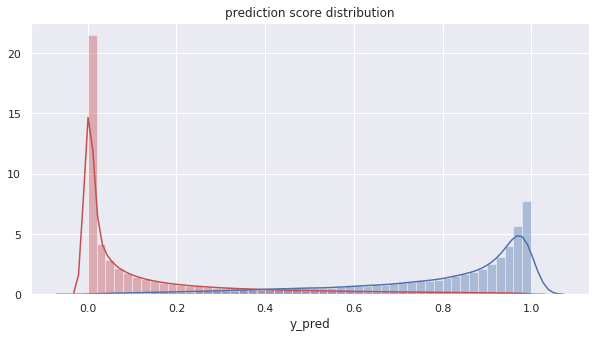

In [13]:
xgb_result_dict = evaluate(x_test.values, y_test.label.values, clf2, 'xgb', feature_cols)

## lightgbm

In [9]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 64,
    'learning_rate': 0.05,
    'num_threads': 50,
}

In [15]:
lgb_trn = lgb.Dataset(sample_x_trn, sample_y_trn, feature_name=feature_cols)
lgb_val = lgb.Dataset(sample_x_val, sample_y_val, feature_name=feature_cols)

In [38]:
t1 = time.time()
clf = lgb.train(lgb_params,
                train_set=lgb_trn,
                valid_sets=[lgb_trn, lgb_val],
                num_boost_round=2000,
                early_stopping_rounds=100,
                verbose_eval=50)
print('elapsed time:', time.time()-t1)

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.898067	valid_1's auc: 0.897205
[100]	training's auc: 0.922432	valid_1's auc: 0.92151
[150]	training's auc: 0.933764	valid_1's auc: 0.932539
[200]	training's auc: 0.940369	valid_1's auc: 0.938888
[250]	training's auc: 0.945129	valid_1's auc: 0.943403
[300]	training's auc: 0.948316	valid_1's auc: 0.946207
[350]	training's auc: 0.950637	valid_1's auc: 0.948097
[400]	training's auc: 0.952634	valid_1's auc: 0.949699
[450]	training's auc: 0.954258	valid_1's auc: 0.950898
[500]	training's auc: 0.955562	valid_1's auc: 0.951733
[550]	training's auc: 0.956792	valid_1's auc: 0.952525
[600]	training's auc: 0.958115	valid_1's auc: 0.953479
[650]	training's auc: 0.959146	valid_1's auc: 0.954111
[700]	training's auc: 0.960164	valid_1's auc: 0.954749
[750]	training's auc: 0.960974	valid_1's auc: 0.95513
[800]	training's auc: 0.961831	valid_1's auc: 0.955601
[850]	training's auc: 0.962453	valid_1's auc: 0.955777
[900]

acc    recall  precision  f1_score       auc
0  0.889109  0.900852   0.132509  0.231035  0.961901

pred: 1  pred: 0
true: 1    60558     6665
true: 0   396451  3171569

feature          desc  importance
44     avg_subscription_period  평균 요금제 변경 주기       13482
49               real_avg_arpu       평균 ARPU       11210
5              svc_scrb_period           NaN       11084
6            last_equip_period           NaN        8450
46             real_arpu_bf_m1       순수 ARPU        6870
48             real_arpu_bf_m3       순수 ARPU        5176
47             real_arpu_bf_m2       순수 ARPU        4922
1                          age            나이        4413
7                  bas_fee_amt        요금제 가격        4266
53            data_usage_ratio           NaN        2982
45            avg_chg_duration      평균 기변 주기        2862
54  bf_m6_data_usage_ratio_avg     데이터 소진 비율        2822
3              mng_nice_cb_scr     나이스 신용 점수        2705
9                  eqp_out_prc        단말 출고가        2675
8              bas_ofr_data_gb           NaN        2333
28      data_usage_in_gb_bf_m2     총 데이터 사용량        2254
26      data_usage_in_gb_bf_m0           NaN        2225
27      data_usage_in_gb_bf_m1     총 데이터 사용량        2158
50           bf_m3_fee_chg_cnt  요금제 변경 횟수 피쳐        1979
11               pmth_inv_bamt     전월 잔여 할부금        1795

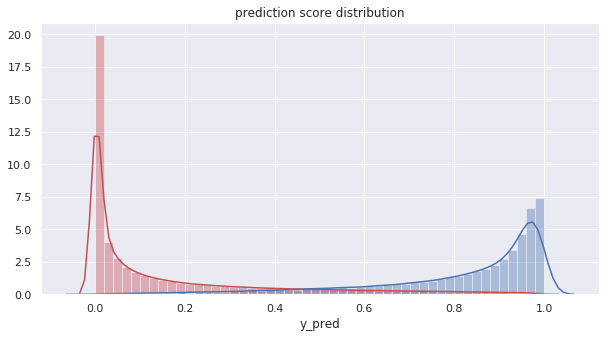

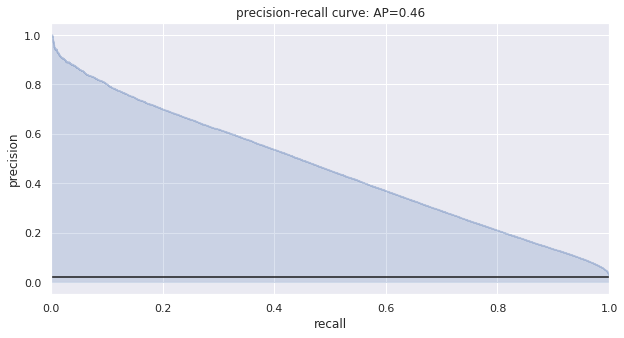

In [19]:
lgb_result_dict = evaluate(x_test, y_test.label.values, clf, 'lgb')

## save

In [22]:
save_model(rf, '../result/model_selection/rf_0703.pkl')
save_model(clf2, '../result/model_selection/xgb_0703.pkl')
save_model(clf, '../result/model_selection/lgb_0703.pkl')

save_model(xgb_result_dict, '../result/model_selection/xgb_result_0703.pkl')
save_model(lgb_result_dict, '../result/model_selection/lgb_result_0703.pkl')

## 결과
- 각각의 AUPRC가 rf(0.12), xgb(0.45), lgb(0.46)으로 rf의 성능이 많이 떨어짐
- xgb, lgb은 거의 비슷한 성능을 보이지만 속도 면에서 lgb가 더 빠름(13분20초 vs 3분20초)
- 앞으로의 실험에서는 lgb를 이용해서 모델링을 수행함

## Evaluate by REAL test data

In [3]:
x_test = pd.read_pickle('../data/real_x_test.pkl')
y_test = pd.read_pickle('../data/real_y_test.pkl')

x_test.shape, y_test.shape

((18580984, 79), (18580984, 1))

In [6]:
feature_cols = list(x_test.columns)

In [4]:
rf = load_model('../result/model_selection/rf_0703.pkl')
xgb = load_model('../result/model_selection/xgb_0703.pkl')
lgb = load_model('../result/model_selection/lgb_0703.pkl')

load model from  ../result/model_selection/rf_0703.pkl
load model from  ../result/model_selection/xgb_0703.pkl
load model from  ../result/model_selection/lgb_0703.pkl


In [5]:
rf_params = {
    'n_estimators': 400,
#     'max_feature': ,
    'max_depth':8,
#     'min_samples_split': ,
#     'bootstrap': ,
    'n_jobs': 30,
    'random_state': 23,
#     'verbose': 2
}

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc', #logloss, error, auc
    'n_estimators': 2000,
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'scale_pos_weight': 4, # neg/pos
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 23,
    'nthread': 60,
    'verbosity': 1
}

lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 64,
    'learning_rate': 0.05,
    'num_threads': 50,
}

acc    recall  precision  f1_score       auc
0  0.975066  0.009788   0.384117  0.019089  0.761121

pred: 1   pred: 0
true: 1     4508    456068
true: 0     7228  18113180

feature              desc  importance
6            last_equip_period               NaN    0.118660
27      data_usage_in_gb_bf_m1         총 데이터 사용량    0.071881
53            data_usage_ratio               NaN    0.068911
28      data_usage_in_gb_bf_m2         총 데이터 사용량    0.065248
44     avg_subscription_period      평균 요금제 변경 주기    0.059451
49               real_avg_arpu           평균 ARPU    0.049796
54  bf_m6_data_usage_ratio_avg         데이터 소진 비율    0.037098
7                  bas_fee_amt            요금제 가격    0.035846
8              bas_ofr_data_gb               NaN    0.027318
56   bf_m3_data_over_usage_cnt      데이터 초과 사용 횟수    0.026349
30                 overage_bf0               NaN    0.025961
48             real_arpu_bf_m3           순수 ARPU    0.024361
58           copn_left_cnt_bf1  쿠폰 소진 후 잔여 쿠폰 건수    0.023282
55   bf_m6_data_over_usage_cnt      데이터 초과 사용 횟수    0.022243
46             real_arpu_bf_m1           순수 ARPU    0.022088
50           bf_m3_fee_chg_cnt      요금제 변경 횟수 피쳐    0.021775
47             real_arpu_bf_m2           순수 ARPU    0.021725
59           copn_left_cnt_bf2  쿠폰 소진 후 잔여 쿠폰 건수    0.021188
5              svc_scrb_period               NaN    0.020469
1                          age                나이    0.019860

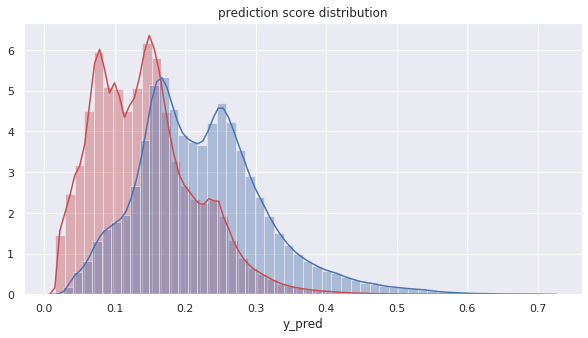

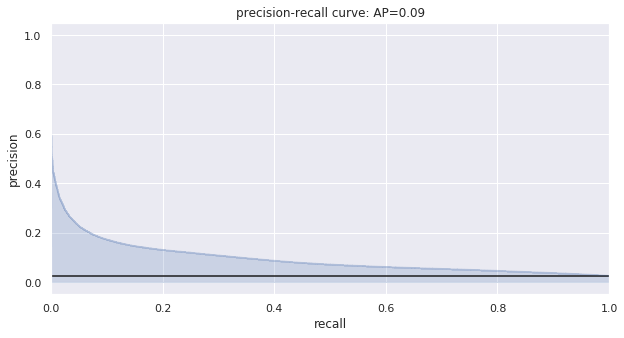

elapsed time:  272.63307452201843


In [8]:
t1 = time.time()
rf_result_dict = evaluate(x_test, y_test.label.values, rf, 'rf')
print('elapsed time: ', time.time()-t1)

acc    recall  precision  f1_score       auc
0  0.916909  0.655573   0.178958  0.281164  0.892692

pred: 1   pred: 0
true: 1   301941    158635
true: 0  1385272  16735136

feature              desc  importance
42                 sec_dev_yn     세컨드 디바이스 보유여부    0.060281
12                  family_yn          가족 결합 여부    0.044345
8             bas_ofr_data_gb               NaN    0.042611
56  bf_m3_data_over_usage_cnt      데이터 초과 사용 횟수    0.042249
6           last_equip_period               NaN    0.039552
44    avg_subscription_period      평균 요금제 변경 주기    0.038704
68            tw_tplan_chk_1m               NaN    0.038354
50          bf_m3_fee_chg_cnt      요금제 변경 횟수 피쳐    0.037904
18   twld_fee_visit_cnt_bf_m0               NaN    0.034523
53           data_usage_ratio               NaN    0.033670
5             svc_scrb_period               NaN    0.033659
49              real_avg_arpu           평균 ARPU    0.031316
46            real_arpu_bf_m1           순수 ARPU    0.031221
7                 bas_fee_amt            요금제 가격    0.028064
58          copn_left_cnt_bf1  쿠폰 소진 후 잔여 쿠폰 건수    0.027073
33      copn_data_u1_yn_bf_m0               NaN    0.023159
27     data_usage_in_gb_bf_m1         총 데이터 사용량    0.023080
47            real_arpu_bf_m2           순수 ARPU    0.020617
78                    channel          요금제 가입채널    0.018895
61           overage_5k_3m_or               NaN    0.018353

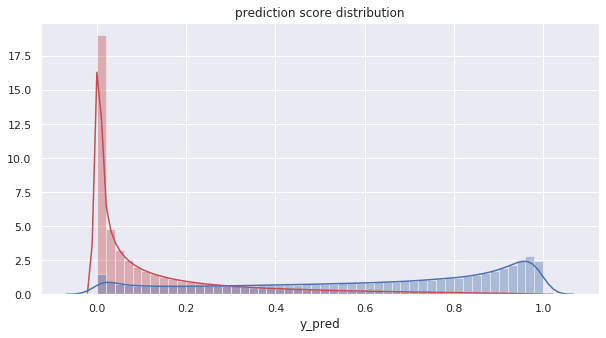

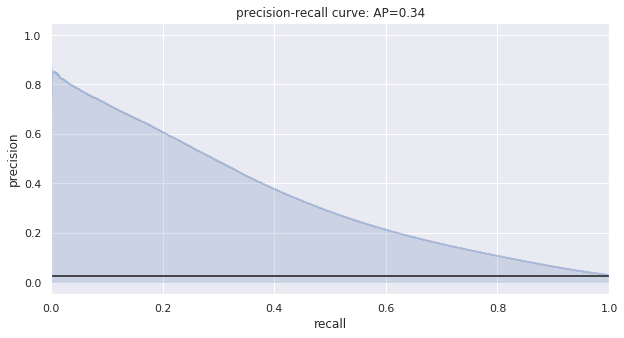

elapsed time:  302.29357743263245


In [9]:
t1 = time.time()
xgb_result_dict = evaluate(x_test.values, y_test.label.values, xgb, 'xgb', feature_cols)
print('elapsed time: ', time.time()-t1)

acc    recall  precision  f1_score     auc
0  0.892163  0.714049   0.149427  0.247137  0.8965

pred: 1   pred: 0
true: 1   328874    131702
true: 0  1872022  16248386

feature          desc  importance
44     avg_subscription_period  평균 요금제 변경 주기       13482
49               real_avg_arpu       평균 ARPU       11210
5              svc_scrb_period           NaN       11084
6            last_equip_period           NaN        8450
46             real_arpu_bf_m1       순수 ARPU        6870
48             real_arpu_bf_m3       순수 ARPU        5176
47             real_arpu_bf_m2       순수 ARPU        4922
1                          age            나이        4413
7                  bas_fee_amt        요금제 가격        4266
53            data_usage_ratio           NaN        2982
45            avg_chg_duration      평균 기변 주기        2862
54  bf_m6_data_usage_ratio_avg     데이터 소진 비율        2822
3              mng_nice_cb_scr     나이스 신용 점수        2705
9                  eqp_out_prc        단말 출고가        2675
8              bas_ofr_data_gb           NaN        2333
28      data_usage_in_gb_bf_m2     총 데이터 사용량        2254
26      data_usage_in_gb_bf_m0           NaN        2225
27      data_usage_in_gb_bf_m1     총 데이터 사용량        2158
50           bf_m3_fee_chg_cnt  요금제 변경 횟수 피쳐        1979
11               pmth_inv_bamt     전월 잔여 할부금        1795

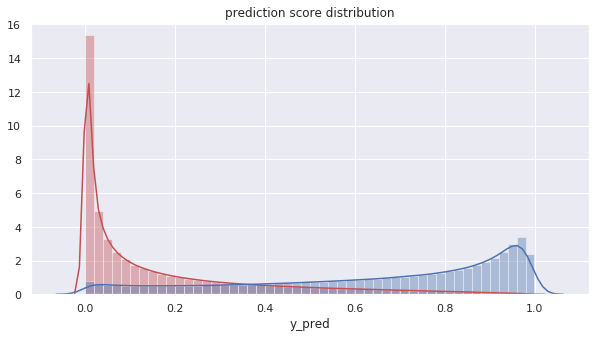

elapsed time:  305.29604268074036


In [10]:
t1 = time.time()
lgb_result_dict = evaluate(x_test, y_test.label.values, lgb, 'lgb')
print('elapsed time: ', time.time()-t1)